In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
import math
import string
import re
import nltk
import contractions

from itertools import islice
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

In [4]:
wine_data = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_data.head(1)

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


## Task 1:  
Identify a dataset to study, and perform an exploratory analysis of the data. Describe the
dataset, including its basic statistics and properties, and report any interesting findings. This
exploratory analysis should motivate the design of your model in the following sections. Datasets
should be reasonably large (e.g. large enough to run the kinds of methods we’ve discussed in
class).


In [10]:
countries = wine_data['country'].unique()
varieties = wine_data['variety'].unique()
wineries = wine_data['winery'].unique()
regions_1 = wine_data['region_1'].unique()

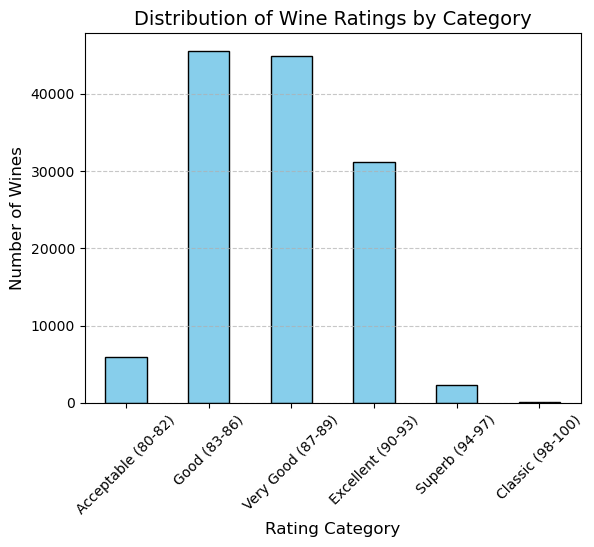

In [12]:
bins = [79, 83, 87, 90, 94, 98, 100]
labels = ["Acceptable (80-82)", "Good (83-86)", "Very Good (87-89)", 
          "Excellent (90-93)", "Superb (94-97)", "Classic (98-100)"]
wine_data['rating_category'] = pd.cut(wine_data['points'], bins=bins, labels=labels, right=True)
rating_counts = wine_data['rating_category'].value_counts(sort=False)
rating_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Wine Ratings by Category", fontsize=14)
plt.xlabel("Rating Category", fontsize=12), plt.ylabel("Number of Wines", fontsize=12), plt.xticks(rotation=45), plt.grid(axis='y', linestyle='--', alpha=0.7);

according to the website the data was scraped from https://www.wineenthusiast.com/ratings/, the rating scale goes as follows: 98-100 = classic, the pinnacle of quality 94-97 = superb, a great achievement 90-93, 87-89 = very good, often good value and well recommended, 83 - 86 = good, suitable for everyday consumption often good value, 80 - 82 = acceptable, can be employed


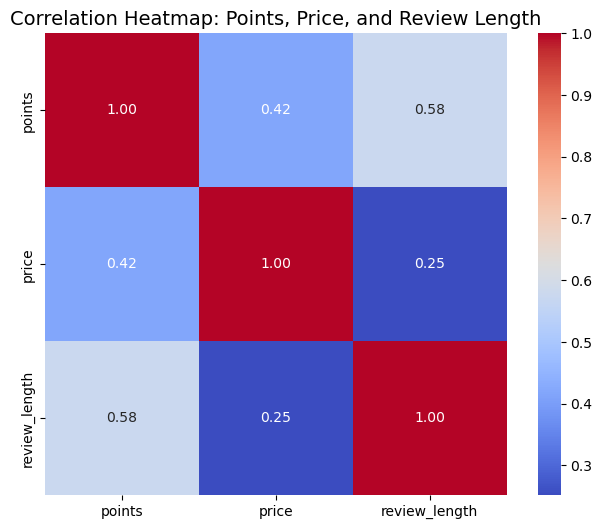

In [15]:
#feature engineering: Add a column for the length of the review
wine_data['review_length'] = wine_data['description'].apply(len)
#select relevant columns for the correlation heatmap
correlation_data = wine_data[['points', 'price', 'review_length']].dropna()
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(8, 6)), sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, square=True);
plt.title("Correlation Heatmap: Points, Price, and Review Length", fontsize=14);

In [17]:
average_ratings_by_country = wine_data.groupby('country')['points'].mean().sort_values(ascending=False)
average_ratings_by_variety = wine_data.groupby('variety')['points'].mean().sort_values(ascending=False)
average_ratings_by_winery = wine_data.groupby('winery')['points'].mean().sort_values(ascending=False)

In [19]:
# Calculate the average points grouped by winery, variety, and region_1 with a minimum count of 5 entries
winery_counts = wine_data.groupby('winery').size()
filtered_winery = winery_counts[winery_counts >= 5].index
average_points_by_winery = (
    wine_data[wine_data['winery'].isin(filtered_winery)]
    .groupby('winery')['points']
    .mean()
    .sort_values(ascending=False)
)
variety_counts = wine_data.groupby('variety').size()
filtered_variety = variety_counts[variety_counts >= 5].index
average_points_by_variety = (
    wine_data[wine_data['variety'].isin(filtered_variety)]
    .groupby('variety')['points']
    .mean()
    .sort_values(ascending=False)
)
region_counts = wine_data.groupby('region_1').size()
filtered_region = region_counts[region_counts >= 5].index
average_points_by_region = (
    wine_data[wine_data['region_1'].isin(filtered_region)]
    .groupby('region_1')['points']
    .mean()
    .sort_values(ascending=False)
)

#display the top results
#print("Top Regions by Average Points:\n", average_points_by_region.head())
#print("Top Wineries by Average Points:\n", average_points_by_winery.head())
#print("\nTop Varieties by Average Points:\n", average_points_by_variety.head())

In [21]:
#check for duplicate entries in the dataset
duplicate_entries = wine_data.duplicated().sum()
#print(f"Number of duplicate entries: {duplicate_entries}")

## Task 2:
_____

In [24]:
#define the bins and labels for the 'rating' column
bins = [79, 89, 100]
labels = ["Standard", "Extraordinary"]

#create the 'rating' column based on the 'points' column
wine_data['label'] = pd.cut(wine_data['points'], bins=bins, labels=labels, right=True)
review_rating_data = wine_data[['description','label']]
review_rating_data.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",Standard
1,"This is ripe and fruity, a wine that is smooth...",Standard
2,"Tart and snappy, the flavors of lime flesh and...",Standard
3,"Pineapple rind, lemon pith and orange blossom ...",Standard
4,"Much like the regular bottling from 2012, this...",Standard


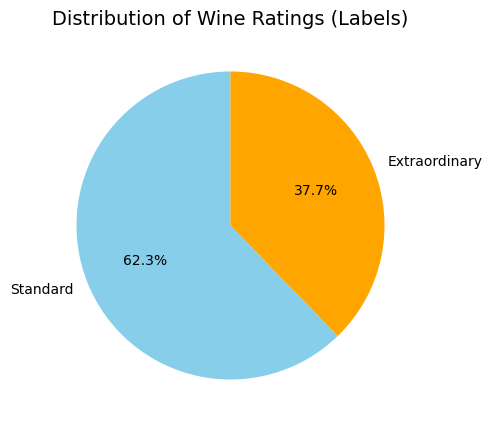

In [26]:
label_distribution = review_rating_data['label'].value_counts()

# Create a pie chart for the distribution of labels
plt.figure(figsize=(5, 5))
label_distribution.plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['skyblue', 'orange'], 
    labels=label_distribution.index
)
plt.title("Distribution of Wine Ratings (Labels)", fontsize=14), plt.ylabel(""), plt.tight_layout();

#function to expand contractions -> this will fix errors with words like "can't" where tokenization and function
def expand_contractions(text):
    return contractions.fix(text)
contraction expansion before tokenization
review_rating_data['description'] = review_rating_data['description'].apply(expand_contractions)

In [29]:
#convert to string values before tokenization
review_rating_data['description'] = review_rating_data['description'].astype(str)

#ensure review column is in string format for tokenization
review_rating_data['tokenized'] = review_rating_data['description'].apply(word_tokenize)

C:\Users\Billy Dang\AppData\Local\Temp\ipykernel_19436\3473510139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_rating_data['description'] = review_rating_data['description'].astype(str)
C:\Users\Billy Dang\AppData\Local\Temp\ipykernel_19436\3473510139.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_rating_data['tokenized'] = review_rating_data['description'].apply(word_tokenize)


In [30]:
#remove stopwords that may not contribute much to meaning
stop_words = set(stopwords.words("english"))
#init punctuation for removal
sp = set(string.punctuation)
#function to traverse and return only words not in stopwords list
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]
review_rating_data['tokenized'] = review_rating_data['tokenized'].apply(remove_stopwords)

C:\Users\Billy Dang\AppData\Local\Temp\ipykernel_19436\162653867.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_rating_data['tokenized'] = review_rating_data['tokenized'].apply(remove_stopwords)


In [31]:
#remove punctuation
def clean_tokens(tokens):
    return [
        re.sub(r'[^\w\s]', '', word).lower()
        for word in tokens
        if re.sub(r'[^\w\s]', '', word).isalpha()
    ]
review_rating_data['review'] = review_rating_data['tokenized'].apply(clean_tokens)

C:\Users\Billy Dang\AppData\Local\Temp\ipykernel_19436\1031538048.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_rating_data['review'] = review_rating_data['tokenized'].apply(clean_tokens)


In [32]:
review_clean = review_rating_data[['review', 'label']]
review_clean.head()

,review,label
0,"[aromas, include, tropical, fruit, broom, brim...",Standard
1,"[ripe, fruity, wine, smooth, still, structured...",Standard
2,"[tart, snappy, flavors, lime, flesh, rind, dom...",Standard
3,"[pineapple, rind, lemon, pith, orange, blossom...",Standard
4,"[much, like, regular, bottling, comes, across,...",Standard


In [33]:
all_words = [word for tokens in review_clean['review'] for word in tokens]
word_counts = Counter(all_words)
common_words = word_counts.most_common(10)

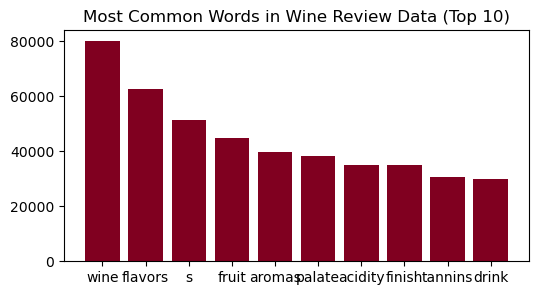

In [34]:
words, counts = zip(*common_words)
plt.figure(figsize = (6,3)), plt.title("Most Common Words in Wine Review Data (Top 10)"), plt.bar(words, counts, color='#800020');

In [35]:
#flatten for positive and negative reviews
extraordinary_words = [word for tokens in review_clean[review_clean['label'] == 'Extraordinary']['review'] for word in tokens]
standard_words = [word for tokens in review_clean[review_clean['label'] == 'Standard']['review'] for word in tokens]
#get counts
extraordinary_counts = Counter(extraordinary_words).most_common(10)
standard_counts = Counter(standard_words).most_common(10)

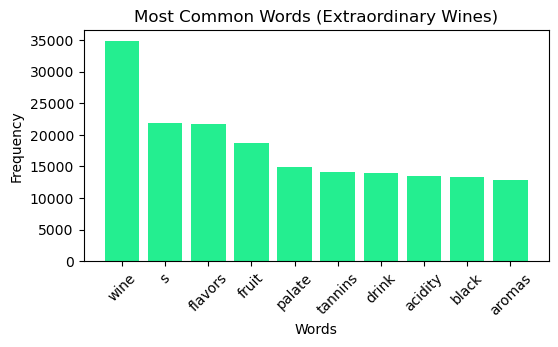

In [36]:
ext_words, ext_counts = zip(*extraordinary_counts)
plt.figure(figsize=(6, 3))
plt.bar(ext_words, ext_counts, color='#24ee90')
plt.title('Most Common Words (Extraordinary Wines)')
plt.xticks(rotation=45), plt.xlabel('Words'), plt.ylabel('Frequency');

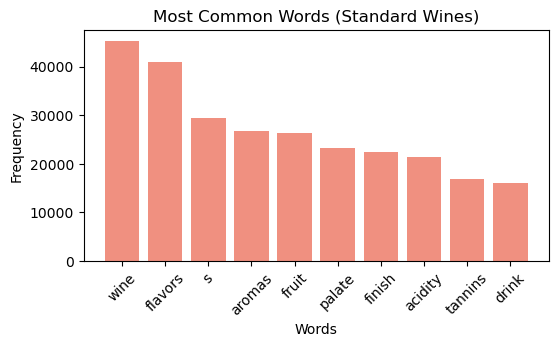

In [37]:
sta_words, sta_counts = zip(*standard_counts)
plt.figure(figsize=(6, 3))
plt.bar(sta_words, sta_counts, color='#f09080')
plt.title('Most Common Words (Standard Wines)')
plt.xticks(rotation=45), plt.xlabel('Words'), plt.ylabel('Frequency');

In [38]:
extra_words = ' '.join([word for tokens in review_clean[review_clean['label'] == 'Extraordinary']['review'] for word in tokens])
stand_words = ' '.join([word for tokens in review_clean[review_clean['label'] == 'Standard']['review'] for word in tokens])

ext_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(extra_words)

sta_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(stand_words)

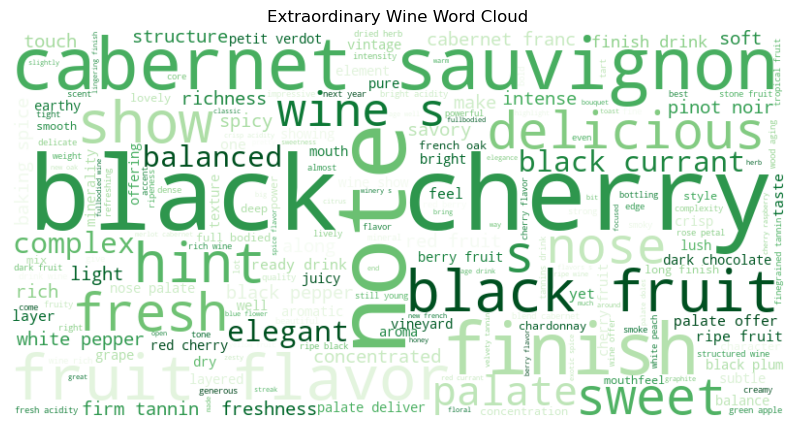

In [39]:
plt.figure(figsize=(10, 6))
plt.imshow(ext_wordcloud, interpolation='bilinear')
plt.axis('off'), plt.title('Extraordinary Wine Word Cloud');

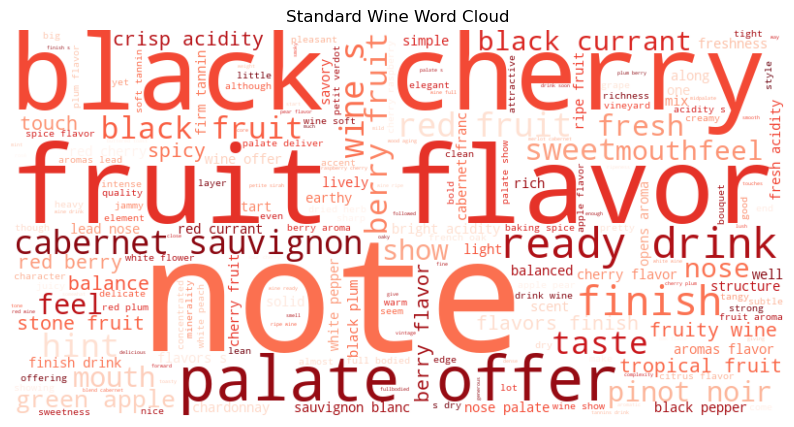

In [40]:
plt.figure(figsize=(10, 6))
plt.imshow(sta_wordcloud, interpolation='bilinear')
plt.axis('off'), plt.title('Standard Wine Word Cloud');

In [41]:
review_clean

,review,label
0,"[aromas, include, tropical, fruit, broom, brim...",Standard
1,"[ripe, fruity, wine, smooth, still, structured...",Standard
2,"[tart, snappy, flavors, lime, flesh, rind, dom...",Standard
3,"[pineapple, rind, lemon, pith, orange, blossom...",Standard
4,"[much, like, regular, bottling, comes, across,...",Standard
...,...,...
129966,"[notes, honeysuckle, cantaloupe, sweeten, deli...",Extraordinary
129967,"[citation, given, much, decade, bottle, age, p...",Extraordinary
129968,"[welldrained, gravel, soil, gives, wine, crisp...",Extraordinary
129969,"[dry, style, pinot, gris, crisp, acidity, also...",Extraordinary


In [42]:
review_clean['review_text'] = review_clean['review'].apply(lambda x: ' '.join(x))

#create a bag of words vectorizer for the top 10000 most common words
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(review_clean['review_text'])

#define y as the 'label' column
y = review_clean['label']

#split data into train and test sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=3)

#initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

#predict on test data
y_pred = log_reg.predict(X_test)

#evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

C:\Users\Billy Dang\AppData\Local\Temp\ipykernel_19436\3056998766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_clean['review_text'] = review_clean['review'].apply(lambda x: ' '.join(x))


Accuracy: 0.8404800984817399

Classification Report:
                precision    recall  f1-score   support

Extraordinary       0.81      0.76      0.78     14714
     Standard       0.86      0.89      0.87     24278

     accuracy                           0.84     38992
    macro avg       0.83      0.82      0.83     38992
 weighted avg       0.84      0.84      0.84     38992



In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for different C values
param_grid = {'C': [0.1, 0.2, 0.5, 0.8, 1, 2, 3]}

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=3)

# Perform grid search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the tuned model on the test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_tuned)
test_report = classification_report(y_test, y_pred_tuned)

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", test_report)

Best Parameters: {'C': 0.5}
Best Cross-Validation Accuracy: 0.840578629295695
Test Accuracy: 0.8410186704965121

Classification Report:
                precision    recall  f1-score   support

Extraordinary       0.81      0.76      0.78     14714
     Standard       0.86      0.89      0.87     24278

     accuracy                           0.84     38992
    macro avg       0.83      0.82      0.83     38992
 weighted avg       0.84      0.84      0.84     38992



In [327]:
# Create a bag of words vectorizer for the top 20,000 most common words
vectorizer_20000 = CountVectorizer(max_features=10000)
X_20000 = vectorizer_20000.fit_transform(review_clean['review_text'])

# Define y as the 'label' column
y = review_clean['label']

# Split the data into train and test sets (70/30 split)
X_train_20000, X_test_20000, y_train_20000, y_test_20000 = train_test_split(
    X_20000, y, test_size=0.3, stratify=y, random_state=3
)

# Initialize and train a logistic regression model
log_reg_20000 = LogisticRegression(max_iter=1000, random_state=3)
log_reg_20000.fit(X_train_20000, y_train_20000)

# Predict on the test set
y_pred_20000 = log_reg_20000.predict(X_test_20000)

# Evaluate model performance
accuracy_20000 = accuracy_score(y_test_20000, y_pred_20000)
report_20000 = classification_report(y_test_20000, y_pred_20000)

print("Accuracy (Top 20000 Words):", accuracy_20000)
print("\nClassification Report (Top 20000 Words):\n", report_20000)


Accuracy (Top 20000 Words): 0.817193270414444

Classification Report (Top 20000 Words):
                precision    recall  f1-score   support

Extraordinary       0.78      0.72      0.75     14714
     Standard       0.84      0.88      0.86     24278

     accuracy                           0.82     38992
    macro avg       0.81      0.80      0.80     38992
 weighted avg       0.82      0.82      0.82     38992



In [339]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Create a TF-IDF vectorizer for the top 10,000 most common words
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(review_clean['review_text'])

# Define y as the 'label' column
y = review_clean['label']

# Split the data into train and test sets (70/30 split)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.3, stratify=y, random_state=42
)

# Initialize and train a logistic regression model
log_reg_tfidf = LogisticRegression(max_iter=1000, random_state=42)
log_reg_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Predict on the test set
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)

# Evaluate model performance
accuracy_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
report_tfidf = classification_report(y_test_tfidf, y_pred_tfidf)

print("Accuracy (TF-IDF Top 10,000 Words):", accuracy_tfidf)
print("\nClassification Report (TF-IDF Top 10,000 Words):\n", report_tfidf)


Accuracy (TF-IDF Top 10,000 Words): 0.8265541649569143

Classification Report (TF-IDF Top 10,000 Words):
                precision    recall  f1-score   support

Extraordinary       0.79      0.73      0.76     14714
     Standard       0.84      0.88      0.86     24278

     accuracy                           0.83     38992
    macro avg       0.82      0.81      0.81     38992
 weighted avg       0.83      0.83      0.83     38992



In [313]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for different C values and kernels for the SVM
param_grid_svm = {'C': [0.01, 0.1], 'kernel': ['linear']}

# Initialize the SVM model
svm_model = SVC(random_state=3)

# Perform grid search with cross-validation
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Get the best parameters and best score from the grid search
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

# Evaluate the tuned model on the test set
best_svm_model = grid_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm)
test_report_svm = classification_report(y_test, y_pred_svm)

print("Best Parameters for SVM:", best_params_svm)
print("Best Cross-Validation Accuracy for SVM:", best_score_svm)
print("Test Accuracy for SVM:", test_accuracy_svm)
print("\nClassification Report for SVM:\n", test_report_svm)


Best Parameters for SVM: {'C': 0.1, 'kernel': 'linear'}
Best Cross-Validation Accuracy for SVM: 0.8394464241497019
Test Accuracy for SVM: 0.8374538366844481

Classification Report for SVM:
                precision    recall  f1-score   support

Extraordinary       0.80      0.75      0.78     14714
     Standard       0.86      0.89      0.87     24278

     accuracy                           0.84     38992
    macro avg       0.83      0.82      0.82     38992
 weighted avg       0.84      0.84      0.84     38992



[literature](https://www.cambridge.org/core/journals/natural-language-engineering/article/uncovering-the-language-of-wine-experts/9BF0A599B49230297FD6DBA01F07C0DD)


In [48]:
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients from the logistic regression model
coefficients = best_model.coef_[0]  # Assuming binary classification

# Create a DataFrame for word importance
word_importance = pd.DataFrame({
    'Word': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients to find the most impactful words
word_importance['AbsCoefficient'] = word_importance['Coefficient'].abs()
word_importance = word_importance.sort_values(by='AbsCoefficient', ascending=False)

# Top impactful words
top_positive = word_importance.sort_values(by='Coefficient', ascending=False).head(10)
top_negative = word_importance.sort_values(by='Coefficient', ascending=True).head(10)

print("Top Words [Standard]:\n", top_positive)
print("\nTop Words [Extraordinary]:\n", top_negative)


Top Words [Standard]:
              Word  Coefficient  AbsCoefficient
4681        lacks     1.795044        1.795044
7912       simple     1.753143        1.753143
9576     virginia     1.696076        1.696076
2946     everyday     1.648123        1.648123
7769           sh     1.602383        1.602383
3679      generic     1.546241        1.546241
9429  valuepriced     1.507001        1.507001
2702    easygoing     1.490397        1.490397
1113       budget     1.439861        1.439861
2242        dasti     1.430614        1.430614

Top Words [Extraordinary]:
                Word  Coefficient  AbsCoefficient
7510         sample    -2.818020        2.818020
3788       gorgeous    -1.878711        1.878711
8593         superb    -1.761339        1.761339
648       beautiful    -1.758704        1.758704
8876       terrific    -1.742931        1.742931
3045      exquisite    -1.723068        1.723068
7190         resist    -1.689537        1.689537
5018       longterm    -1.684403       

In [315]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [316]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(best_svm_model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Visualize the most important words for the classification
shap.summary_plot(shap_values, feature_names=vectorizer.get_feature_names_out())


NotImplementedError: adding a nonzero scalar to a sparse matrix is not supported

In [319]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create a baseline model that always predicts the most frequent label
baseline_model = DummyClassifier(strategy="most_frequent", random_state=3)
baseline_model.fit(X_train, y_train)

# Predict on the test set using the baseline model
y_baseline_pred = baseline_model.predict(X_test)

# Generate the classification report and accuracy for the baseline model
baseline_accuracy = accuracy_score(y_test, y_baseline_pred)
baseline_report = classification_report(y_test, y_baseline_pred)

print("Baseline Model Accuracy:", baseline_accuracy)
print("\nBaseline Model Classification Report:\n", baseline_report)

C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Baseline Model Accuracy: 0.6226405416495692

Baseline Model Classification Report:
                precision    recall  f1-score   support

Extraordinary       0.00      0.00      0.00     14714
     Standard       0.62      1.00      0.77     24278

     accuracy                           0.62     38992
    macro avg       0.31      0.50      0.38     38992
 weighted avg       0.39      0.62      0.48     38992



C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [347]:
# Feature engineering: Add review length as the length of the 'description' column
wine_data['review_length'] = wine_data['description'].astype(str).apply(len)

# Handle missing values in 'price' by filling with the median value
wine_data['price'] = wine_data['price'].fillna(wine_data['price'].median())

# One-hot encoding for 'variety' and 'winery'
variety_ohe = pd.get_dummies(wine_data['variety'], prefix='variety')

# Combine features into a new DataFrame
classification_data = pd.concat([
    wine_data[['price', 'review_length', 'label']],  # Include price, review_length, and label
    variety_ohe
], axis=1)

# Drop rows with missing labels if any
classification_data = classification_data.dropna(subset=['label'])

In [351]:
# Define features (X) and target (y)
X = classification_data.drop('label', axis=1)
y = classification_data['label']

# Perform a 70/30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=4)

# Initialize and fit a logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=3)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)


C:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7821091505949939

Classification Report:
                precision    recall  f1-score   support

Extraordinary       0.76      0.62      0.68     14714
     Standard       0.79      0.88      0.83     24278

     accuracy                           0.78     38992
    macro avg       0.78      0.75      0.76     38992
 weighted avg       0.78      0.78      0.78     38992

